#**Submitters**
# - Yazan Yehya, ID: 314659756
# - Rami Sima'an, ID: 212272751


# Deep Q-Network for Atari Breakout.

In this assignment you are required to implement a Deep Q-Network agent, for the Atari game Breakout.

You need to submit your code, along with a plot of the rewards during training, and a video of an episode with the trained agent.


__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for PyTorch, but you'll find it easy to adapt it to almost any Python-based deep learning framework.

In [ ]:
!pip install setuptools==65.5.0 "wheel<0.40.0"
!pip install stable-baselines3[extra] ale-py==0.7.4 gym==0.21.0
!pip install pyglet==1.5.27
!pip install pyvirtualdisplay

In [ ]:
import os
import random
import numpy as np
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !apt-get -qq install -y xvfb
    os.environ['DISPLAY'] = ':1'

display = Display(visible=0, size=(400, 300))
display.start()


## Breakout

This is an environment emulating the Atari game *Breakout*. The goal is to break all the bricks in the wall without letting the ball touch the floor. You have 5 lives and get points more points for higher brick than for the lower ones.

The observation is an image with dimensions (210, 160, 3).

There are 4 actions defined as NOOP, FIRE, LEFT and RIGHT.

See full description [here](https://www.gymlibrary.dev/environments/atari/breakout/).




observation dim (210, 160, 3) number of actions 4


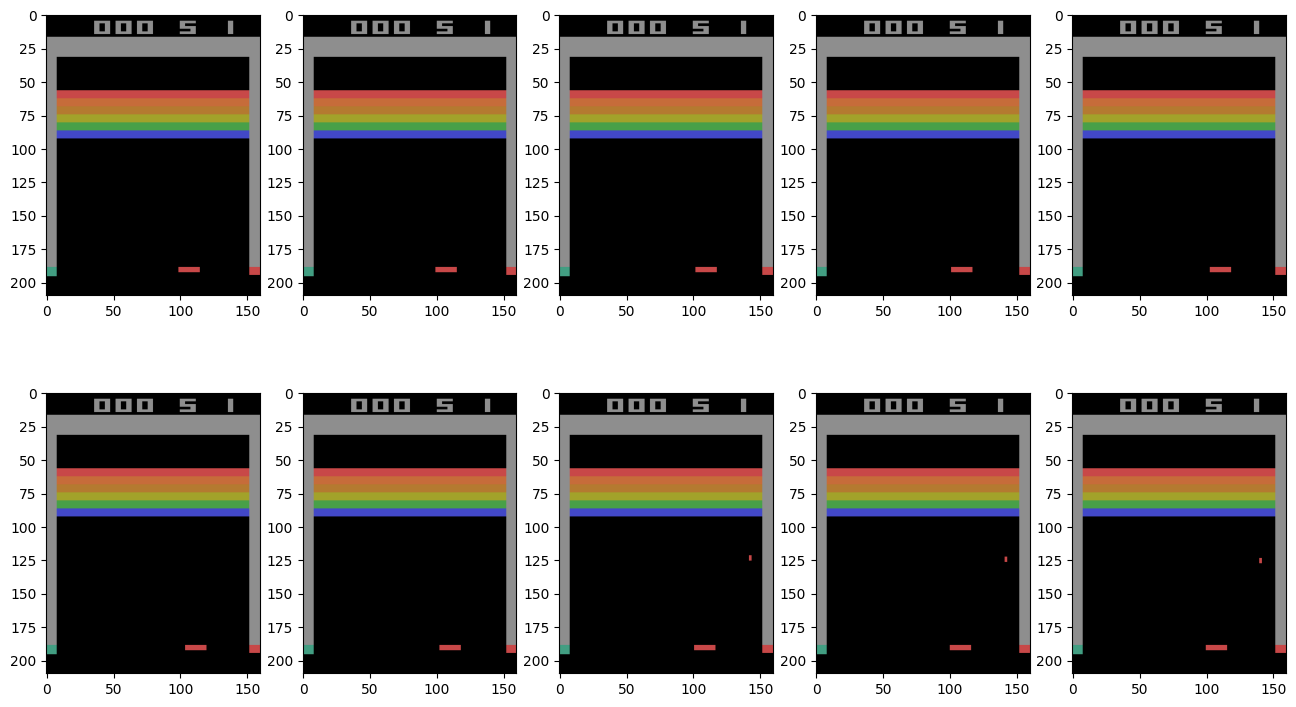

In [ ]:
ENV_NAME = "BreakoutNoFrameskip-v4"
env = gym.make(ENV_NAME)
obs = env.reset()

n_actions = env.action_space.n
obs_dim = obs.shape
print("observation dim", obs_dim, "number of actions", n_actions)


n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        #ax.imshow(obs)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

## Wrappers

In order to make the environment more suitable for RL training, we make the following updates to the environment, using environment wrappers:
1. Preprocess the images to contain only the relevant part of the image, converted to grayscale. The raw images are large and we can do with 64x64 images.
2. Concatenate the 4 previous images (in order to capture dynamics)
3. Start the fire action automatically when starting the episode
4. Repeat the same action for 4 time steps
5. Output the maximum values of the last 2 frames per pixel (in order to prevent blinking)
6. Ouput a "done" signal every time a life is reduced but only reset the environment when all lives are gone
7. Bin the rewards to the values {-1, 0, 1}




In [ ]:
from gym.core import Wrapper
from gym.spaces.box import Box
from gym.core import ObservationWrapper
from gym.spaces import Box
import cv2

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def observation(self, img):
        """what happens to each observation"""

        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        img = img[34:-16, 8:-8, :]
        img = cv2.resize(img, self.img_size[1:])
        img = (img*np.array([[[0.8, .1, .1]]])).sum(-1, keepdims=True)  # grayscale with more weight for red (accelerates training)
        img = img.astype('float32') / 255.
        return img.transpose((2, 0, 1))

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros(
            (2,) + env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = ClipRewardEnv(env)

    # This wrapper preprocesses observations
    env = PreprocessAtariObs(env)
    return env

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError(
                'dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)


def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env
env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

## Check observations under wrappers

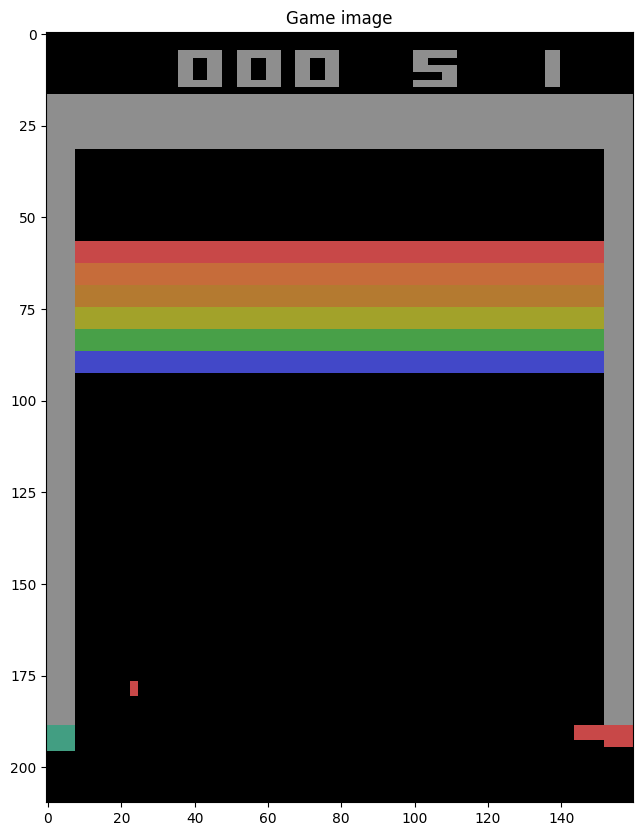

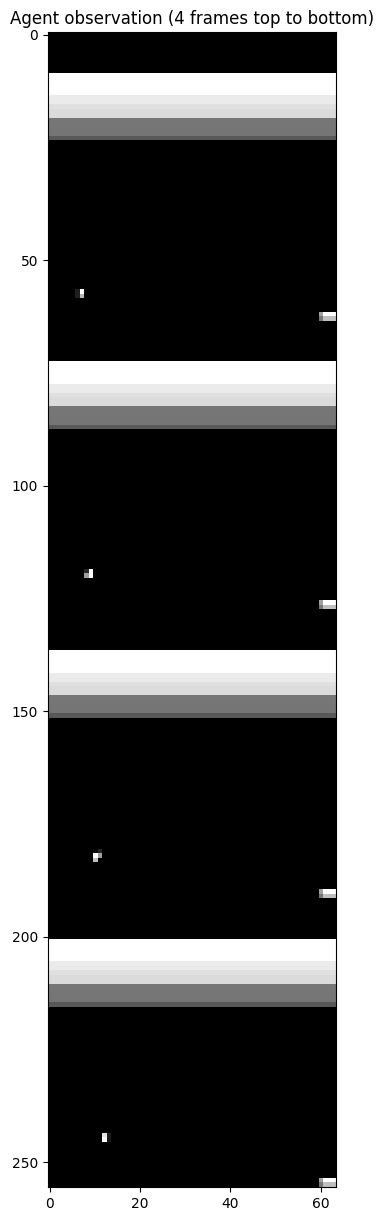

In [ ]:
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(obs.reshape([-1, state_shape[2]]), cmap='gray')
plt.show()

## Random Agent

Here we implement a random agent to use in the 'evaluate' function, that runs the agent through multiple epsiodes.

In [ ]:
class RandomAgent():
    def __init__(self, n_actions):
        self.n_actions = n_actions


    def get_qvalues(self, states):
        return np.random.normal(size=(1,self.n_actions,))

    def sample_actions(self, qvalues):
        return np.random.randint(self.n_actions, size=(1,))

## Video generation

## Assignment

Implement a DQN agent that contains:
1. A neural network that predicts the q-values for a given observation.
2. An experience replay buffer where all transitions are added.
3. A target Q-network that is formed by periodically copying the weights of the main Q-nework.

You will also need to implement the training loop, and submit a figure showing the reward as a function of the training step, and a video showing an episode with the trained agent.

# Connecting to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Implementation of our Agent and Training Process

In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque
import cv2

# Set the environment name
ENV_NAME = "BreakoutNoFrameskip-v4"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



####################################################################################################################
######################################### Implementation our Agent #################################################
####################################################################################################################

# Define the DQN agent class
def conv2d_size_out(size, kernel_size, stride):
    return (size - (kernel_size - 1) - 1) // stride  + 1

class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):
        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        state_dim = state_shape[0]
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=state_dim, out_channels=16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=conv2d_size_out(conv2d_size_out(conv2d_size_out(64,3,2), 3, 2), 3, 2)**2 * 64, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=n_actions)
        )
        self.frames = 0
        self.epsilon = 1.0


        # return qvalues
    def forward(self, x):
        return self.network(x)

    # Define the select_action method
    def select_action(self, state):
        # Pass the state to the agent to compute Q-values
        q_values = agent.get_qvalues(state)
        self.frames += 1
        # Apply epsilon-greedy strategy
        if self.frames < 50000 or np.random.rand() < agent.epsilon:
            # Randomly select an action
            action = np.random.randint(self.n_actions)
        else:
            # Select the action with the highest Q-value
            action = q_values.argmax()

        return action
    def get_qvalues(self, state):
        # Convert the state to a tensor if needed
        state_tensor = torch.FloatTensor([state]).to(device)

        # Compute Q-values using the network
        with torch.no_grad():
            q_values = self.network(state_tensor)

        return q_values.squeeze().detach().cpu().numpy()


####################################################################################################################
######################################### END of Implementation our Agent ##########################################
####################################################################################################################


####################################################################################################################
######################################## Implementation our Buffer #################################################
####################################################################################################################

from collections import deque

class CircularBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        self.size = 0

    def append(self, item):
        self.buffer.append(item)
        if self.size < self.capacity:
            self.size += 1

    def sample(self, batch_size):
        return random.sample(self.buffer, min(batch_size, self.size))

####################################################################################################################
######################################### End of Implementation our Buffer##########################################
####################################################################################################################



####################################################################################################################
######################################## Implementation  our Training procces ######################################
####################################################################################################################


# Plot the total rewards
def train_dqn(agent, env, num_episodes=100, max_steps_per_episode=10000, batch_size=32, target_update=1000, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=1e-6, print_interval=1000, plot_interval=2500):
    optimizer = optim.Adam(agent.parameters(), lr=5e-5)
    criterion = nn.SmoothL1Loss()

    # Create circular buffer for experience replay
    replay_buffer = CircularBuffer(capacity=100000)

    target_net = DQNAgent(env.observation_space.shape, env.action_space.n).to(device)  # Initialize target network
    target_net.load_state_dict(agent.state_dict())
    target_net.to(device)  # Move target_net to the same device as agent
    target_net.eval()
    total_rewards = []
    episode_rewards = []

    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        total_reward = 0  # Track the total reward for the current episode
        steps = 0  # Track the number of steps in the current episode

        for timestamp in range(max_steps_per_episode):

            action = agent.select_action(obs)  # Select an action based on the current observation

            next_obs, reward, done, _ = env.step(action)  # Take the action and observe the next state

            replay_buffer.append((obs, action, reward, next_obs, done))  # Store the transition in the buffer
            obs = next_obs  # Update the current observation
            total_reward += reward  # Update the total reward
            steps += 1  # Increment the step counter

            # Update epsilon (exploration rate)
            if agent.epsilon > epsilon_end:
                # epsilon = np.interp(agent.frames, [0, epsilon_decay], [epsilon_start, epsilon_end])
                agent.epsilon -= epsilon_decay

            # Perform training
            if replay_buffer.size > batch_size and steps % 4 == 0:  # Sample every 4th step

                batch = replay_buffer.sample(batch_size)  # Sample a batch of transitions from the buffer
                obs_batch, action_batch, reward_batch, next_obs_batch, done_batch = map(np.array, zip(*batch))  # Unpack the batch into separate arrays



                obs_batch = torch.FloatTensor(obs_batch).to(device) # Move input tensors to the same device as the model
                action_batch = torch.LongTensor(action_batch).to(device)  # Move action tensors to the same device as the model
                reward_batch = torch.FloatTensor(reward_batch).to(device)  # Move reward tensors to the same device as the model
                next_obs_batch = torch.FloatTensor(next_obs_batch).to(device)  # Move next observation tensors to the same device as the model
                done_batch = torch.BoolTensor(done_batch).to(device)  # Move done tensors to the same device as the model

                q_values = agent(obs_batch)  # Compute Q-values for the current observations

                next_q_values = target_net(next_obs_batch).detach()  # Compute Q-values for the next observations using the target network
                target_q_values = reward_batch + 0.99 * next_q_values.max(dim=1)[0] * ~done_batch  # Compute the target Q-values

                # Compute the loss and optimize the network
                q_value = q_values.gather(1, action_batch.unsqueeze(1)).squeeze(1)


                loss = criterion(q_value, target_q_values) #Compute loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                #Update target network
            if agent.frames % target_update == 0:
                target_net.load_state_dict(agent.state_dict())

            if done or steps >= max_steps_per_episode:  # Check if maximum steps per episode reached
                total_rewards.append(total_reward)
                episode_rewards.append(total_reward)
                avg_reward = np.mean(episode_rewards[-print_interval:])
                if episode % print_interval == 0:
                    print(f"Steps: {steps} Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")
                    print(f"Average Reward (Episodes {max(0, episode - print_interval-1)}-{episode + 1}): {avg_reward}")
                break  # Break the loop when episode ends or maximum steps reached


        if episode % plot_interval == 0:
            # Calculate average reward for every 100 episodes
            avg_rewards = [np.mean(total_rewards[i:i + 100]) for i in range(0, len(total_rewards), 100)]

            # Plot total rewards
            plt.plot(range(len(total_rewards)), total_rewards, label='Total Reward')

            # Plot average rewards
            plt.plot(range(0, len(total_rewards), 100), avg_rewards, label='Average Reward (Last 100 Episodes)', color='red', linewidth=1)

            plt.xlabel('Episode')
            plt.ylabel('Reward')
            plt.title('Total and Average Rewards per Episode')
            plt.legend()
            plt.show()

            # Save model after plotting
            torch.save(agent.state_dict(), os.path.join("/content/drive/MyDrive/Colab Notebooks/", f"model_{episode}_run_6.pth"))
            # Calculate average reward for every 100 episodes
    avg_rewards = [np.mean(total_rewards[i:i + 100]) for i in range(0, len(total_rewards), 100)]

    # Plot total rewards
    plt.plot(range(len(total_rewards)), total_rewards, label='Total Reward')

     # Plot average rewards
    plt.plot(range(0, len(total_rewards), 100), avg_rewards, label='Average Reward (Last 100 Episodes)', color='red', linewidth=1)

    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Total and Average Rewards per Episode')
    plt.legend()
    plt.show()


    # Save models
    torch.save(target_net.state_dict(), "/content/drive/MyDrive/Colab Notebooks/target_net1.pth")
    torch.save(agent.state_dict(), os.path.join("/content/drive/MyDrive/Colab Notebooks/", "model1.pth"))

    with open("/content/drive/MyDrive/Colab Notebooks/total_rewards1.txt", "w") as f:
      for reward in total_rewards:
        f.write(str(reward) + "\n")

    return total_rewards, avg_rewards, target_net


####################################################################################################################
################################### End of Implementation our Training procces #####################################
####################################################################################################################




cuda


# Evaluate our Agent and record a video in the environment

In [ ]:


import gym.wrappers
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML
def evaluate_and_record(env, agent, n_games=3, greedy=False, t_max=100000, video_dir="videos"):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []

    # Record game sessions
    with gym.wrappers.Monitor(env, directory=video_dir, force=True) as env_monitor:
        env_monitor.reset()
        agent.network.eval()
        agent.epsilon = 0
        for _ in range(n_games):
            s = env_monitor.reset()
            reward = 0
            for _ in range(t_max):
                qvalues = agent.get_qvalues(s)
                action = qvalues.argmax() if greedy else agent.select_action(qvalues)
                s, r, done, _ = env_monitor.step(action)
                reward += r
                if done:
                    break
            rewards.append(reward)

    return np.mean(rewards)

# Define Agent and load trained model

In [ ]:

# Definition our agent, and put it at the same device
agent = DQNAgent(env.observation_space.shape, env.action_space.n).to(device)




############################################ Train the DQN agent ################################################
# total_rewards, avg_rewards, target_net = train_dqn(agent, env)





####################################################################################################################
################################### Loading our trained agent and it's rewards #####################################
####################################################################################################################


agent.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/model.pth"))

total_rewards = []
with open("/content/drive/MyDrive/Colab Notebooks/total_rewards.txt", "r") as f:
  for line in f:
    total_rewards.append(float(line.strip()))

####################################################################################################################
####################################################################################################################
####################################################################################################################


# Ploting results of our Tranied model

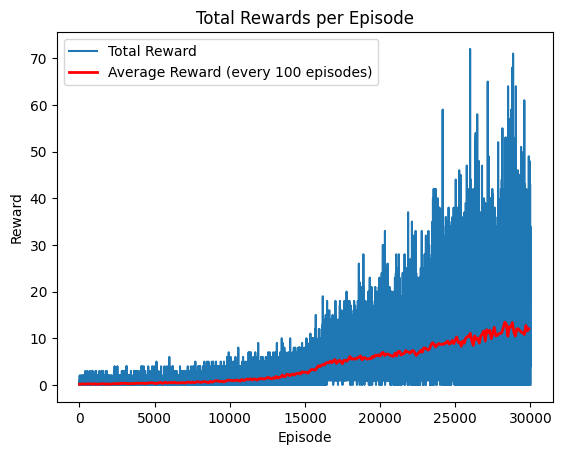

In [ ]:
average_rewards_100 = [np.mean(total_rewards[i:i+100]) for i in range(0, len(total_rewards), 100)]

# Plot total rewards per episode
plt.plot(total_rewards, label='Total Reward')
# Plot average of every 100 episodes
plt.plot(range(0, len(total_rewards), 100), average_rewards_100, 'r-', linewidth=2, label='Average Reward (every 100 episodes)')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Total Rewards per Episode')
plt.legend()
plt.show()

# Evaluate the agent

In [ ]:

evaluation_rewards = evaluate_and_record(env, agent, greedy=True, n_games=1)
print(f"Evaluation Reward: {np.mean(evaluation_rewards)}")
print(f"Total Rewards: {np.mean(total_rewards)}")


Evaluation Reward: 38.0
Total Rewards: 4.282733333333334


# Show Video of the Game

In [ ]:
video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices (if n_games>1)

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))